In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl

# Exercise 01

* Scatterplot the $N$ observations, for all ($D \times D$) pairs of variables.

Here, we will load the data found in "exercise_01_data.csv" and use pandas' scatter_matrix method to plot the loaded data as asked.

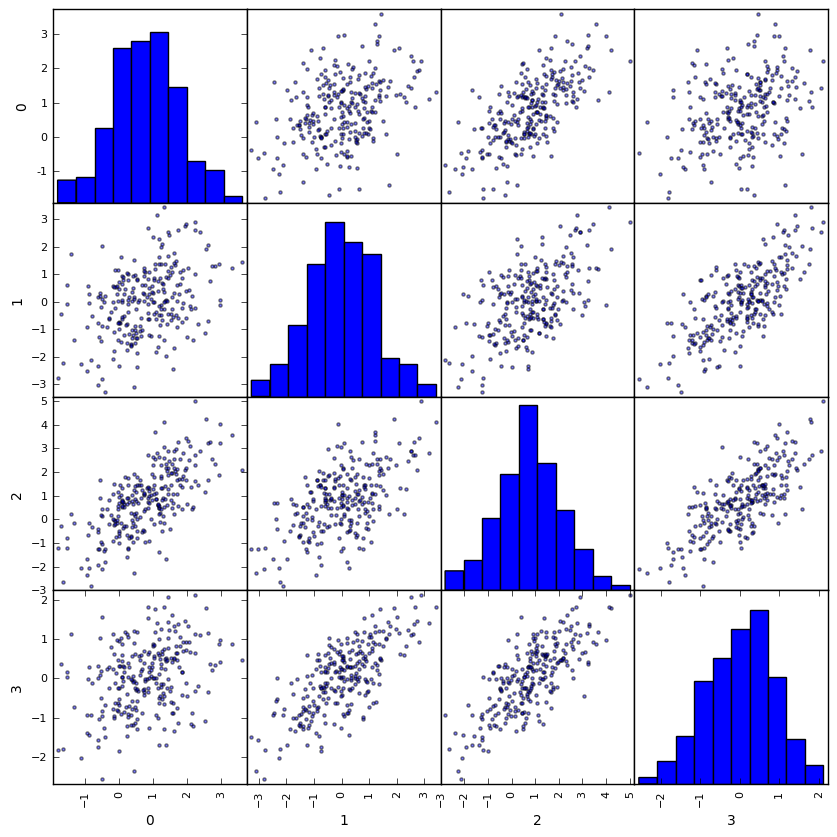

In [2]:
df = pd.read_csv("exercise_01_data.csv", header=None)
pd.scatter_matrix(df, figsize=(10,10));

* Estimate the parameters of the distribution by maximum likelihood

As we have a multivariate gaussian distribution, we have to estimate two parameters: $\mu_{ML}$, which is the $4 \times 1$ mean vector of the distribution; and $\Sigma_{ML}$, which is the $4 \times 4$ covariance matrix.

The value of $\mu_{ML}$ is $$\mu_{ML} = \frac{1}{N}\sum\limits_{k=1}^{N} x_k$$ where $N$ is the size of the dataset. Then, we find it by:

In [3]:
def mean_mle(data):
    N = len(data)
    mean = np.array([0., 0., 0., 0.])
    
    for x in data:
        mean += x
    
    return mean/N
    
mean = mean_mle(df.values)
mean

array([ 0.77074788,  0.02057762,  0.79679207,  0.03159737])

The covariance matrix $\Sigma_{ML}$ is a bit trickier to find. It is given by the expression $$\Sigma_{ML} = \frac{1}{N-1}\sum\limits_{k=1}^{N} (x_n - \mu_{ML})(x_n - \mu_{ML})^T$$ which depends on the value of $\mu_{ML}$ estimated above. Then, we find it by:

In [4]:
def cov_mle(data, mean):
    N = len(data)
    d = len(data[0])
    cov = np.zeros(shape=(d,d))
    
    for i, x in enumerate(data):
        cov += np.outer((x - mean), np.transpose(x - mean))
    
    return cov/(N-1)
    
cov = cov_mle(df.values, mean)
cov

array([[ 0.96985688,  0.45770964,  0.93039732,  0.28576257],
       [ 0.45770964,  1.54539296,  0.97809671,  0.79607766],
       [ 0.93039732,  0.97809671,  1.87452175,  0.89015443],
       [ 0.28576257,  0.79607766,  0.89015443,  0.75185405]])

* Calculate the (estimated) mean vector $\mu_{a \vert b}$, covariance matrix $\Sigma_{a \vert b}$ and precision matrix $\Lambda_{a \vert b}$ of the Gaussian distribution $p(x_a \vert x_b)$, for $M = 2$ and for $M = 1$. You are free to set $x_b$.

We know, from the linear gaussian model, that $$\mu_{a \vert b} = \mu_a + \Sigma_{ab}\Sigma_{bb}^{-1}(x_b - \mu_b)$$ and $$\Sigma_{a \vert b} = \Sigma_{aa} - \Sigma_{ab}\Sigma_{bb}^{-1}\Sigma_{ba}$$ Then, we can calculate these values as follows:

In [5]:
'''
Note that:
    sigma_aa = cov[:m, :m]
    sigma_ab = cov[:m, m:]
    sigma_ba = cov[m:, :m]
    sigma_aa = cov[m:, m:]
'''

def cond_mean(mean, cov, xb, m):
    return mean[:m] + np.dot(np.dot(cov[:m,m:], np.linalg.pinv(cov[m:,m:])), (xb - mean[m:]))

def cond_cov(cov, m):
    return cov[:m, :m] - np.dot(np.dot(cov[:m, m:], np.linalg.pinv(cov[m:, m:])), cov[m:, :m])

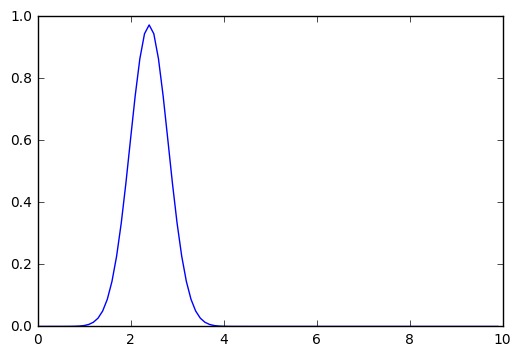

In [6]:
m=1
mean_m1 = cond_mean(mean, cov, np.array(df.values)[0, m:], m)
cov_m1 = cond_cov(cov, m)
v = []
for x in np.arange(0,10,0.1):
    v += [stats.norm.pdf(x, mean_m1[0], cov_m1[0])]

plt.plot(np.arange(0,10,0.1), v)    

[ 2.40667102  1.93830008]
[[ 0.43407566  0.12946543]
 [ 0.12946543  0.7009475 ]]


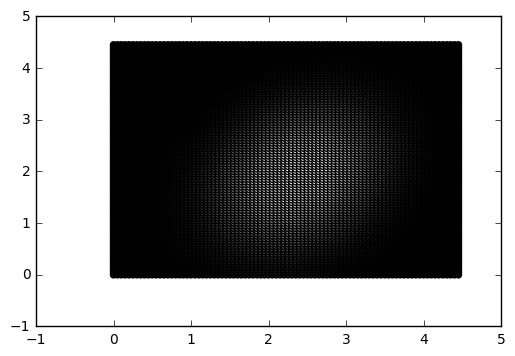

In [12]:
def bi_gaussian(x, mean, sigma):
    return stats.multivariate_normal.pdf(x, mean=mean, cov=sigma)

m=2
mean_m2 = cond_mean(mean, cov, np.array(df.values)[0, m:], m)
cov_m2 = cond_cov(cov, m)
print(mean_m2)
print(cov_m2)
zs = []

interval = np.arange(0, 4.5, 0.05)

for x,y in zip(interval, interval):
    zs += [stats.multivariate_normal.pdf((x,y), mean=mean_m2, cov=cov_m2)]
    
plt.scatter([x for x in interval for y in interval], [y for x in interval for y in interval], 
            c=[bi_gaussian(x, mean_m2, cov_m2) for x in [[x,y] for x in interval for y in interval]], 
            cmap=mpl.cm.Greys_r)